# Adult Dataset

In [1]:
import sys
sys.path.append('../')

import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline

from fairlearn.reductions import ExponentiatedGradient, BoundedGroupLoss, ZeroOneLoss, DemographicParity, GridSearch

import seaborn as sns

from utils import *
from demv import DEMV

import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')

In [2]:
def load_dataset():
  lab_enc = LabelEncoder()
  ord_enc = OrdinalEncoder()
  column_names = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status',
                  'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss',
                  'hours-per-week', 'native-country', 'income']
  adult_df = pd.read_csv('data2/adult.data', names=column_names)
  adult_df.drop(adult_df[(adult_df['race'] != ' Black') & (
      adult_df['race'] != ' White')].index, inplace=True)
  adult_df.loc[adult_df['native-country'] ==
                ' ?', 'native-country'] = 'Not known'
  adult_df['age_class'] = pd.cut(adult_df['age'],
                                  bins=[0, 9, 19, 29, 39, 49, 59, 69, 99],
                                  labels=['age<10', 'age between 10 and 20', 'age between 20 and 30',
                                          'age between 30 and 40', 'age between 40 and 50',
                                          'age between 50 and 60', 'age between 60 and 70', 'age>70']
                                  )
  adult_df['hour-per-week-class'] = pd.cut(adult_df['hours-per-week'],
                                            bins=[0, 9, 19, 29, 39, 49, 99],
                                            labels=['hour<10', 'hours between 10 and 20', 'hours between 20 and 30',
                                                    'hours between 30 and 40', 'hour between 40 and 50',
                                                    'hour>70']
                                            )
  adult_df.drop(labels=['hours-per-week', 'workclass', 'fnlwgt', 'capital-gain', 'capital-loss', 'age', 'education-num'],
                axis=1, inplace=True)
  adult_df = adult_df.join(pd.get_dummies(
      adult_df['education'])).drop('education', axis=1)
  adult_df = adult_df.join(pd.get_dummies(
      adult_df['marital-status'])).drop('marital-status', axis=1)
  adult_df = adult_df.join(pd.get_dummies(
      adult_df['occupation'])).drop('occupation', axis=1)
  adult_df = adult_df.join(pd.get_dummies(
      adult_df['relationship'])).drop('relationship', axis=1)
  adult_df = adult_df.join(pd.get_dummies(
      adult_df['native-country'])).drop('native-country', axis=1)
  adult_df = adult_df.join(pd.get_dummies(
      adult_df['age_class'])).drop('age_class', axis=1)
  adult_df = adult_df.join(pd.get_dummies(
      adult_df['hour-per-week-class'])).drop('hour-per-week-class', axis=1)
  adult_df['income'] = lab_enc.fit_transform(adult_df['income'])
  adult_df[['sex', 'race']] = ord_enc.fit_transform(
      adult_df[['sex', 'race']])
  return adult_df


In [3]:
data = load_dataset()

In [4]:
label = 'income'
sensitive_features = ['race', 'sex']
unpriv_group = {'sex': 0, 'race': 0}
positive_label = 1

In [5]:
pipeline = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        (
            "classifier",
            LogisticRegression(),
        ),
    ]
)

## Biased data

In [6]:
model, bias_metrics = cross_val(pipeline, data, label, unpriv_group, sensitive_features, positive_label=positive_label)

In [7]:
print_metrics(bias_metrics)

Statistical parity:  -0.17  +-  0.016
Disparate impact:  0.174  +-  0.067
Zero one loss:  0.156  +-  0.01
F1 score:  0.829  +-  0.007
Accuracy score:  0.835  +-  0.007


## Grid Search

In [8]:
grid = GridSearch(pipeline, DemographicParity(),
                  sample_weight_name="classifier__sample_weight")
model, grid_metrics = cross_val(grid, data.copy(), label, unpriv_group, sensitive_features, positive_label, exp=True)
save_metrics('grid', 'adult', grid_metrics)


In [9]:
print_metrics(grid_metrics)

Statistical parity:  -0.366  +-  0.007
Disparate impact:  1.0  +-  0.0
Zero one loss:  0.237  +-  0.011
F1 score:  0.783  +-  0.004
Accuracy score:  0.771  +-  0.005


## DEMV

In [10]:
demv_data = data.copy()
demv = DEMV(round_level=1)

In [11]:
model, demv_metrics = cross_val(pipeline, demv_data, label, unpriv_group, sensitive_features, debiaser=demv, positive_label=positive_label)

Training time: ~27 min

In [12]:
iters = demv.get_iters()

In [13]:
print_metrics(demv_metrics)

Statistical parity:  -0.097  +-  0.021
Disparate impact:  0.485  +-  0.11
Zero one loss:  0.142  +-  0.015
F1 score:  0.823  +-  0.004
Accuracy score:  0.832  +-  0.004


## DEMV evaluation

In [14]:
metrics = eval_demv(200, 1081, data.copy(), pipeline, label, unpriv_group, sensitive_features, positive_label=positive_label)

##  Blackbox Postprocessing

In [15]:
model, blackboxmetrics, pred = cross_valbin(pipeline, data, label, unpriv_group, sensitive_features, positive_label=positive_label)


Pre-adjustment group rates are 

 group    fpr    tpr
   0.0 0.0916 0.5871
   1.0 0.0449 0.3143

And loss is 0.1665


Pre-adjustment group rates are 

 group    fpr    tpr
   0.0 0.0786 0.5935
   1.0 0.0193 0.2895

And loss is 0.1568


Pre-adjustment group rates are 

 group    fpr    tpr
   0.0 0.0796 0.5738
   1.0 0.0286 0.5152

And loss is 0.1613


Pre-adjustment group rates are 

 group    fpr    tpr
   0.0 0.0838 0.5866
   1.0 0.0346 0.2500

And loss is 0.1655


Pre-adjustment group rates are 

 group    fpr    tpr
   0.0 0.0907 0.6177
   1.0 0.0246 0.3056

And loss is 0.1597


Pre-adjustment group rates are 

 group    fpr    tpr
   0.0 0.0894 0.5682
   1.0 0.0276 0.4878

And loss is 0.1671


Pre-adjustment group rates are 

 group    fpr    tpr
   0.0 0.0941 0.5297
   1.0 0.0222 0.4091

And loss is 0.1810


Pre-adjustment group rates are 

 group    fpr    tpr
   0.0 0.0782 0.5775
   1.0 0.0303 0.3235

And loss is 0.1584


Pre-adjustment group rates are 

 group    fpr    tpr
 

##  Plot

Training time: 205 mins

In [16]:
df = prepareplots(metrics,'adult')

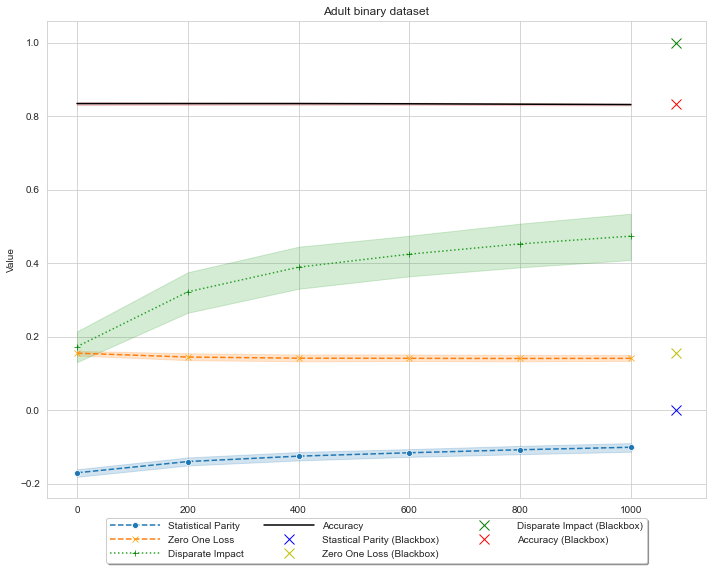

In [17]:
#iters = 1000
points = preparepoints(blackboxmetrics, demv.get_iters())

plot_metrics_curves(df, points, 'Adult binary dataset')

In [18]:
unprivpergentage(data,unpriv_group, demv.get_iters())

Dataset size: 30940
Unprivileged group size: 1555
Percentage of unprivileged group: 5.025856496444732
Number of iterations: 1081


In [19]:
save_metrics('blackbox', 'adult', blackboxmetrics)